In [13]:
id = 1
pID = 'sub-' + "%01d" % (id)

In [14]:
import os

import pandas as pd
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
# from sklearn.ensemble import RandomForestClassifier as RFC
# from sklearn.ensemble import AdaBoostClassifier as ABC

from sklearn.model_selection import cross_val_score, KFold

import pickle, json, os
import scipy.io

# from bci_funcs import windowed_mean, base_correct, select_mean, slope

# path = '/Volumes/Lukas_Gehrke/fastReach/data/eeglab2python'
# path = 'P:\\Lukas_Gehrke\\fastReach\\data\\eeglab2python'
# path = '/Users/lukasgehrke/Documents/publications/2022-CHI-neuroadaptive-haptics/data/5_single-subject-EEG-analysis'
path = '/Volumes/Lukas_Gehrke/NAH/data/5_single-subject-EEG-analysis'

# Neuroadaptive Haptics BCI Training

In [15]:
# load data
erp = scipy.io.loadmat(path+os.sep+pID+os.sep+'erp.mat')['erp']
gaze_vel = scipy.io.loadmat(path+os.sep+pID+os.sep+'gaze_velocity.mat')['gaze_velocity']

# pandas load design matrix called behavior
behavior = pd.read_csv(path+os.sep+pID+os.sep+'behavior_s'+str(id)+'.csv', sep=';')

## Select Data and Assign to Classes

In [16]:
# Simplest approach: select indeces in behavior where answerID is > median
low = behavior[behavior['answerID'] > behavior['answerID'].mean()].index # ! change to median
high = behavior[behavior['answerID'] < behavior['answerID'].mean()].index # ! change to median

# better ideas?

### Plot ERP

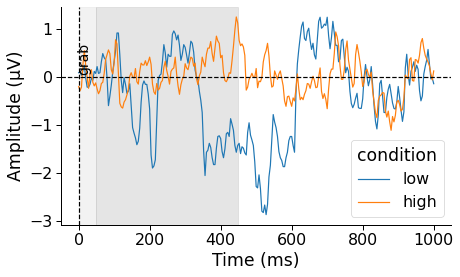

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# erp low
erp_low = erp[:,:,low]
# erp high
erp_high = erp[:,:,high]

plot_erp_low = np.mean(erp_low[-1,:,:], axis=1)
plot_erp_high = np.mean(erp_high[-1,:,:], axis=1)

# ! fix for final correct baseline correction -> however this is just for plot
plot_erp_low = plot_erp_low - np.mean(plot_erp_low[0:12])
plot_erp_high = plot_erp_high - np.mean(plot_erp_high[0:12])

# merge both conditions
df = pd.DataFrame()
# voltage vector
df['low'] = plot_erp_low
df['high'] = plot_erp_high

# melt
df = pd.melt(df, value_vars=['low', 'high'], var_name='condition', value_name='voltage')

# time vector
df['time'] = np.tile(np.arange(0, len(plot_erp_low)),2)# - 50
df['time'] = df['time'] * 1/250 * 1000

with sns.plotting_context('paper', font_scale = 1.8):

    ### Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(7,4))
    fig.patch.set_alpha(1)

    sns.despine() #bottom=True, left=True

    # sns.lineplot(x='time', y='voltage', hue='condition', style='control', data=df, ax=ax, errorbar='ci')
    sns.lineplot(x='time', y='voltage', hue='condition', data=df, ax=ax, errorbar='ci')
    # sns.lineplot(x='time', y='voltage', hue='control', data=df, ax=ax, errorbar='ci')

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude (μV)')

    # xline at 0 with text label 's'
    ax.axvline(0, color='black', linestyle='--')
    ax.text(-5, .1, 'grab', fontsize=14, rotation=90)

    # yline at 0
    ax.axhline(0, color='black', linestyle='--')

    # ! mark area of feature extraction add a grey background to the y axis range 100 - 300ms
    ax.axvspan(50, 450, color='grey', alpha=0.2, label='features')
    ax.axvspan(0, 50, color='grey', alpha=0.1, label='baseline')

    # move legend to the right
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # save as eps
    # plt.tight_layout()
    # plt.savefig('/Users/lukasgehrke/Desktop/erp_diff.pdf', format='pdf', dpi=300)

# Compute Features & Model fitting

In [21]:
# ERP - windowed mean:
# calculate 8 windowed means for every 12 samples -> 50ms
num_windows = 8
window_size = 12
baseline_ix = 0

erp_low = erp[:,:,low]
# baseline correction
baseline = erp_low[:,baseline_ix:baseline_ix+12,:].mean(axis=1)
erp_low = erp_low[:,baseline_ix+13:baseline_ix+13+num_windows*window_size,:] - baseline[:,np.newaxis,:]
# Reshape erp_low
reshaped_erp = erp_low.reshape(erp_low.shape[0], num_windows, window_size, erp_low.shape[2])
# Calculate the mean across the window dimension
windowed_mean = reshaped_erp.mean(axis=2)
# Flatten dimensions 0 and 1 keeping dim 2
windowed_mean_low = windowed_mean.reshape(windowed_mean.shape[0]*windowed_mean.shape[1], windowed_mean.shape[2])

erp_high = erp[:,:,high]
# baseline correction
baseline = erp_high[:,baseline_ix:baseline_ix+12,:].mean(axis=1)
erp_high = erp_high[:,baseline_ix+13:baseline_ix+13+num_windows*window_size,:] - baseline[:,np.newaxis,:]
# Reshape erp_high
reshaped_erp = erp_high.reshape(erp_high.shape[0], num_windows, window_size, erp_high.shape[2])
# Calculate the mean across the window dimension
windowed_mean = reshaped_erp.mean(axis=2)
# Flatten dimensions 0 and 1 keeping dim 2
windowed_mean_high = windowed_mean.reshape(windowed_mean.shape[0]*windowed_mean.shape[1], windowed_mean.shape[2])

# Spectral

# EYE - gaze velocity
gaze_low = gaze_vel[low,:].T
gaze_low = gaze_low[baseline_ix:baseline_ix+num_windows*window_size,:]
gaze_low = gaze_low.reshape(num_windows, window_size, gaze_low.shape[1])
gaze_low = gaze_low.mean(axis=1)

gaze_high = gaze_vel[high,:].T
gaze_high = gaze_high[baseline_ix:baseline_ix+num_windows*window_size,:]
gaze_high = gaze_high.reshape(num_windows, window_size, gaze_high.shape[1])
gaze_high = gaze_high.mean(axis=1)

# EYE - time to first target fixation
fixation_low = np.array(behavior.loc[low, 'fix_delay']).reshape(1, -1)
fixation_high = np.array(behavior.loc[high, 'fix_delay']).reshape(1, -1)

# concat all low features
features_low = np.concatenate((windowed_mean_low, gaze_low, fixation_low), axis=0)
# concat all high features
features_high = np.concatenate((windowed_mean_high, gaze_high, fixation_high), axis=0)

### Plot Features

#### Time to first fixation on target

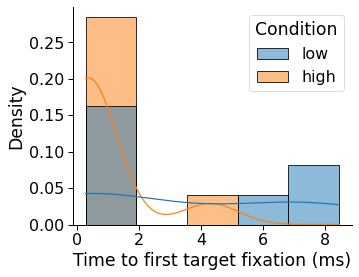

In [24]:
data = np.concatenate((fixation_low, fixation_high), axis = 1).T
low_class = np.zeros((features_low.shape[1], 1))
high_class = np.ones((features_high.shape[1], 1))
classes = np.concatenate((low_class, high_class)).ravel()

data_to_plot = pd.DataFrame(data)
data_to_plot['Condition'] = classes
# rename zeros in Condition to low and ones to high
data_to_plot['Condition'] = data_to_plot['Condition'].replace({0: 'low', 1: 'high'})
data_to_plot = data_to_plot.melt(id_vars = 'Condition', value_name = 'amplitude')

import seaborn as sns
import matplotlib.pyplot as plt

with sns.plotting_context('paper', font_scale = 1.8):

    ### Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(5,4))
    fig.patch.set_alpha(1)

    sns.despine() #bottom=True, left=True

    sns.histplot(x="amplitude", hue="Condition", data=data_to_plot, kde=True, fill=True, stat="density", legend=True)

    # xlabel
    plt.xlabel('Time to first target fixation (ms)')


### Fit Model and Cross-validate

In [46]:
data = np.concatenate((features_low, features_high), axis = 1).T
low_class = np.zeros((features_low.shape[1], 1))
high_class = np.ones((features_high.shape[1], 1))
classes = np.concatenate((low_class, high_class)).ravel()

clf = LDA(solver='eigen', shrinkage='auto')
clf.fit(data, classes)
kfolds = KFold(n_splits=5, random_state=1, shuffle=True) 
cv_results = cross_val_score(clf, data, classes, cv=kfolds)
acc = cv_results.mean()
acc_std = cv_results.std()
print("LDA accuracy: " + str(cv_results.mean()) + " +/- " + str(cv_results.std()))
### END ###

predictions_prob = clf.predict_proba(data)
pred_classes = clf.predict(data)
# get LDA scores
scores = clf.decision_function(data)

# save model
filename = path+os.sep+pID+os.sep+'model.sav'
pickle.dump(clf, open(filename, 'wb'))

# create 4 boundaries from scores using percentiles for decision making
boundaries = np.percentile(scores, [20, 40, 60, 80])

# pickle boundaries
filename = path+os.sep+pID+os.sep+'boundaries.sav'
pickle.dump(boundaries, open(filename, 'wb'))

LDA accuracy: 0.4 +/- 0.13333333333333333


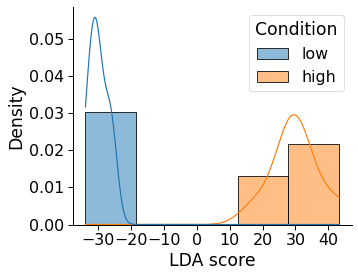

In [45]:
# plot histogram of scores

data_to_plot = pd.DataFrame(scores)
data_to_plot['Condition'] = classes
# rename zeros in Condition to low and ones to high
data_to_plot['Condition'] = data_to_plot['Condition'].replace({0: 'low', 1: 'high'})
data_to_plot = data_to_plot.melt(id_vars = 'Condition', value_name = 'score')

import seaborn as sns

with sns.plotting_context('paper', font_scale = 1.8):

    ### Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(5,4))
    fig.patch.set_alpha(1)

    sns.despine() #bottom=True, left=True

    sns.histplot(x="score", hue="Condition", data=data_to_plot, kde=True, fill=True, stat="density", legend=True)

    # xlabel
    plt.xlabel('LDA score')



### ROC

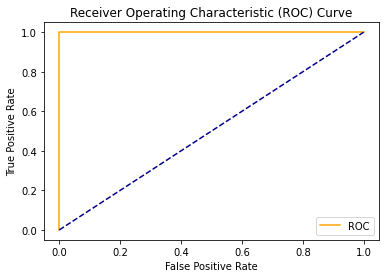

Threshold value is: 0.9999999846937295
F1 Score: 1.0
Threshold used is: 0.9999999846937295


In [29]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def interp_roc_curve(true, score, by ='fp', byval = np.linspace(0,1,101)):
    fp, tp, th =  roc_curve(true, score)
    data = {'fp': fp, 'tp': tp, 'th': th}
    interpData = {}
    for k,v in data.items():
        if k==by:
            interpData[k] = byval
        else:
            interpData[k] = np.interp(byval, data[by], data[k])
    roc = pd.DataFrame.from_dict(interpData)
    return(roc)

roc = interp_roc_curve(classes, predictions_prob[:,1])

false_positive_rate, recall, thresholds = roc_curve(classes, predictions_prob[:,1])

np.savetxt(path+os.sep+pID+os.sep+'fpr.csv', roc.fp, delimiter=',')
np.savetxt(path+os.sep+pID+os.sep+'recall.csv', roc.tp, delimiter=',')

roc_auc = auc(false_positive_rate, recall)
plot_roc_curve(false_positive_rate, recall)

optimal_idx = np.argmax(recall - false_positive_rate)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

from sklearn.metrics import f1_score
f1 = f1_score(classes, pred_classes)
print("F1 Score: "+ str(f1_score(classes, pred_classes)))

# threshold = cv_results.mean()
threshold = np.min(thresholds[false_positive_rate<.2])
print("Threshold used is:", threshold)

### BCI parameters

In [47]:
# TODO fix parameters for BCI
# data_srate = 250
# windows = 10
# baseline = data_srate/windows
target_class = 1

bci_params = dict(((k, eval(k)) for k in ('target_class', 'f1', 'threshold', 'acc', 'acc_std')))
with open(path+os.sep+pID+os.sep+'bci_params.json', 'w') as f:
    json.dump(bci_params, f)
print(bci_params)

{'target_class': 1, 'f1': 1.0, 'threshold': 0.9999999846937295, 'acc': 0.4, 'acc_std': 0.13333333333333333}
